<a href="https://colab.research.google.com/github/techpvk/EVR1/blob/main/s7/Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

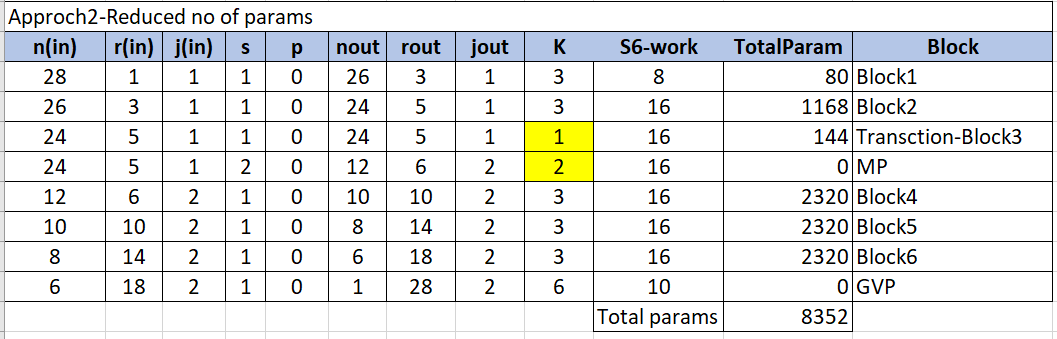

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           2,304
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13724423944950104 Batch_id=468 Accuracy=86.77: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]



Test set: Average loss: 0.1210, Accuracy: 9662/10000 (96.62%)

EPOCH: 1


Loss=0.049121882766485214 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]



Test set: Average loss: 0.0670, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.037967581301927567 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]



Test set: Average loss: 0.0557, Accuracy: 9831/10000 (98.31%)

EPOCH: 3


Loss=0.020447781309485435 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]



Test set: Average loss: 0.0399, Accuracy: 9879/10000 (98.79%)

EPOCH: 4


Loss=0.07383409142494202 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]



Test set: Average loss: 0.0373, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.09813421964645386 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]



Test set: Average loss: 0.0307, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.026725172996520996 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]



Test set: Average loss: 0.0333, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.055252134799957275 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]



Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)

EPOCH: 8


Loss=0.06827990710735321 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]



Test set: Average loss: 0.0296, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.0114867202937603 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]



Test set: Average loss: 0.0292, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.06546715646982193 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]



Test set: Average loss: 0.0274, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss=0.0224114041775465 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]



Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.023746944963932037 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:23<00:00, 19.77it/s]



Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.05220719799399376 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.01145288348197937 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:23<00:00, 20.31it/s]



Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.14083093404769897 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]



Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.0228834617882967 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]



Test set: Average loss: 0.0231, Accuracy: 9919/10000 (99.19%)

EPOCH: 17


Loss=0.04421849921345711 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]



Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.014970882795751095 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]



Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.029064374044537544 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)



In [ ]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

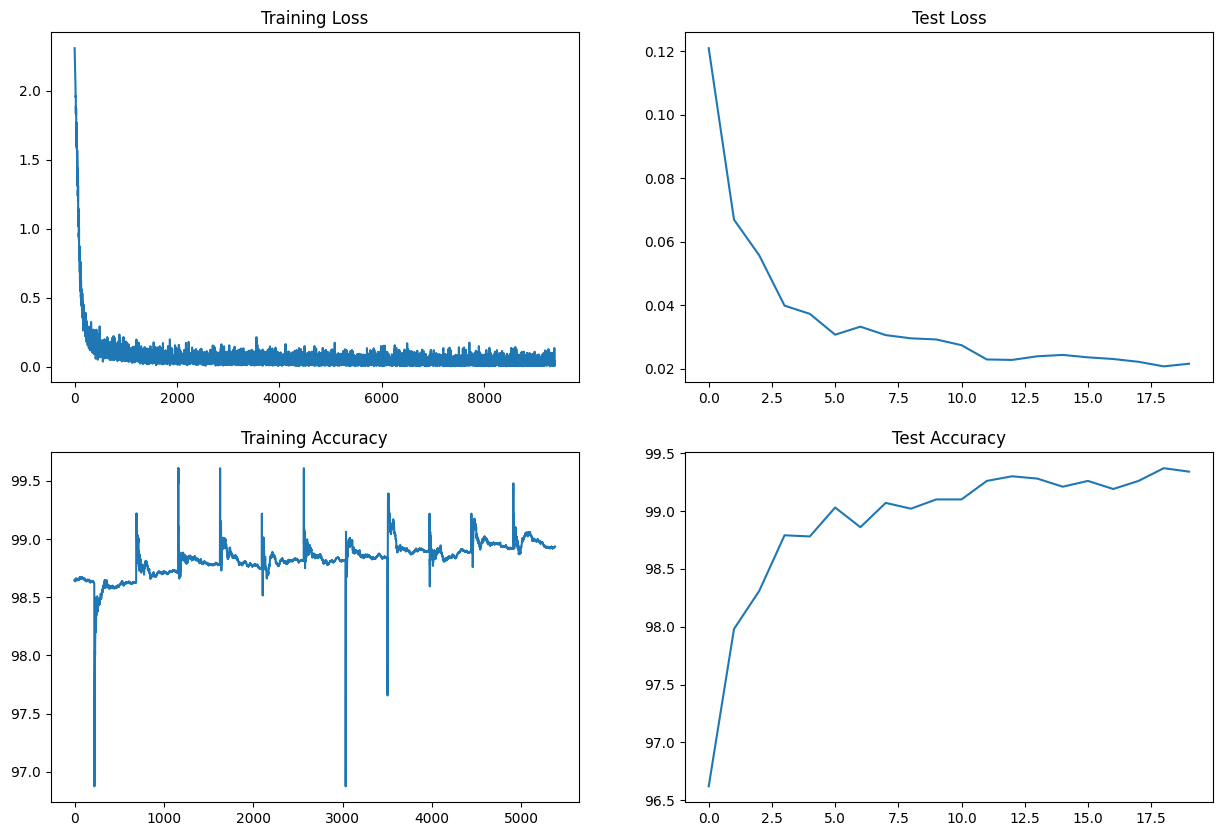

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")